In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import prince

from dataprep.pipeline import get_split, get_data
from models.evaluate import get_confusion_matrix
import config

In [3]:
df_train, df_val = get_split()

#df_train = pd.concat([df_train, df_val])

In [4]:
df_train

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,CabinDeck,CabinNum,CabinSide
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0,B,0.0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1,F,0.0,S
2,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0,A,0.0,S
3,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1,F,1.0,S
4,0005_01,Earth,False,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,1,F,0.0,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7421,9274_01,NaN,True,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,0.0,1,G,1508.0,P
7422,9275_02,Europa,False,TRAPPIST-1e,32.0,False,1.0,1146.0,0.0,50.0,34.0,0,A,97.0,P
7423,9275_03,Europa,NaN,TRAPPIST-1e,30.0,False,0.0,3208.0,0.0,2.0,330.0,1,A,97.0,P
7424,9276_01,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,0,A,98.0,P


In [12]:
df_complete = (df_train
               .assign(n_null=lambda x: x.isnull().sum(axis=1))
               #.query('n_null == 0')
               #.drop('n_null', axis=1)
               .reset_index(drop=False)
              )
df_complete

,index,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,CabinDeck,CabinNum,CabinSide,n_null
0,0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0,B,0.0,P,0
1,1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1,F,0.0,S,0
2,2,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0,A,0.0,S,0
3,3,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1,F,1.0,S,0
4,4,0005_01,Earth,False,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,1,F,0.0,P,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7421,7421,9274_01,NaN,True,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,0.0,1,G,1508.0,P,1
7422,7422,9275_02,Europa,False,TRAPPIST-1e,32.0,False,1.0,1146.0,0.0,50.0,34.0,0,A,97.0,P,0
7423,7423,9275_03,Europa,NaN,TRAPPIST-1e,30.0,False,0.0,3208.0,0.0,2.0,330.0,1,A,97.0,P,1
7424,7424,9276_01,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,0,A,98.0,P,0


In [55]:
pd.crosstab(df_complete['CabinSide'], df_complete['HomePlanet'], normalize='index')

HomePlanet,Earth,Europa,Mars
CabinSide,,,
P,0.544277,0.236262,0.219461
S,0.537436,0.269744,0.192821


In [26]:
pd.crosstab(df_complete['VIP'], df_complete['HomePlanet'], normalize='index')

HomePlanet,Earth,Europa,Mars
VIP,,,
False,0.554433,0.242908,0.202660
True,0.000000,0.661972,0.338028


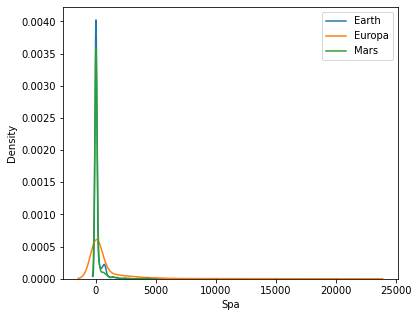

In [79]:
_, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.kdeplot(df_complete.query('HomePlanet=="Earth"').Spa, label='Earth', ax=ax)
sns.kdeplot(df_complete.query('HomePlanet=="Europa"').Spa, label='Europa', ax=ax)
sns.kdeplot(df_complete.query('HomePlanet=="Mars"').Spa, label='Mars', ax=ax)
ax.legend()

In [74]:
def _impute_home_planet(df):
    df = df.copy()
    
    def impute(row):
        if type(row['HomePlanet']) == str:
            return row['HomePlanet']
        else:
            if row['CabinDeck'] in ('A', 'B', 'C', 'T'):
                return 'Europa'
            elif (row['Destination'] == 'PSO J318.5-22') or (row['CabinDeck'] == 'G'):
                return 'Earth'
            elif row['RoomService'] >= 900:
                return 'Mars'
            elif row['VIP']:
                return 'Europa'
            else:
                return 'Earth'
    
    df['HomePlanet'] = df.apply(impute, axis=1)
    return df

In [75]:
mlb_home_planet = MultiLabelBinarizer()
scaler_age = MinMaxScaler()
age_median = df_train.Age.median()
common_destination = df_train.Destination.mode().item()
mlb_destination = MultiLabelBinarizer()

scaler_bill = MinMaxScaler()
mlb_cabin = MultiLabelBinarizer()
scaler_cabin = MinMaxScaler()
cabin_num_median = df_train.CabinNum.median()

decks = pd.crosstab(df_train['CabinDeck'], df_train['Transported'])
decks = (decks[1] / decks.sum(axis=1)).reset_index().rename({0: 'transported_ratio'}, axis=1)

pca = prince.PCA(n_components=3)
mca = prince.MCA(n_components=4)


def _filter_features_columns(df):
    cols = [col for col in df.columns if col.startswith('feat_')]
    cols.append('PassengerId')
    return df.filter(cols)


def process_home_planet(df, train=False):
    df = _impute_home_planet(df)
    df = df.filter(['PassengerId', 'HomePlanet'])
    #df['HomePlanet'] = df.HomePlanet.fillna('Earth')
    seq = df.HomePlanet.values.reshape(-1, 1)
    if train:
        mlb_home_planet.fit(seq)
    feats = mlb_home_planet.transform(seq)
    for i, c in enumerate(mlb_home_planet.classes_):
        df[f'feat_HomePlanet={c}'] = feats[:, i]
    return _filter_features_columns(df)


def process_cryosleep(df, train=False):
    df = df.filter(('PassengerId', 'CryoSleep'))
    df['CryoSleep'] = df.CryoSleep.fillna(False)  # Mode
    df['feat_CyroSleep'] = df['CryoSleep'].astype(int)
    return _filter_features_columns(df)


def process_destination(df, train=False):
    df = df.filter(['PassengerId', 'Destination'])
    df['Destination'] = df.Destination.fillna(common_destination)
    if train:
        mlb_destination.fit(df['Destination'].values.reshape(-1, 1))
    feats = mlb_destination.transform(df['Destination'].values.reshape(-1, 1))
    for i, col in enumerate(mlb_destination.classes_):
        df[f'feat_{col}'] = feats[:, i]
    return _filter_features_columns(df)


def process_vip(df, train=False):
    df = df.filter(['PassengerId', 'VIP'])
    df['VIP'] = df.VIP.fillna(False)
    df['feat_VIP'] = df.VIP.astype(int)
    return _filter_features_columns(df)


def process_age(df, train=False):
    df = df.filter(('PassengerId', 'Age'))
    df['Age'] = df.Age.fillna(age_median)
    ages = df.Age.values.reshape(-1, 1)
    if train:
        scaler_age.fit(ages)
    df['feat_age'] = scaler_age.transform(ages)
    df['feat_is_child'] = (df['Age'] < 18).astype(int)
    return _filter_features_columns(df)


def process_bill(df, train=False):
    cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df = df.filter(['PassengerId'] + cols)
    df = df.fillna(0.)
    
    if train:
        scaler_bill.fit(df[cols].values)
    
    norm_bills = scaler_bill.transform(df[cols].values)
    feat_cols = []
    for i, col in enumerate(cols):
        feat_col = f'feat_{col}'
        df[feat_col] = norm_bills[:, i]
        feat_cols.append(feat_col)
    df['feat_total_norm_bill'] = df[feat_cols].sum(axis=1)
    return _filter_features_columns(df)


def process_cabin(df, train=False):
    cat_cols = ['CabinSide']
    df = df.filter(['PassengerId'] + cat_cols + ['CabinNum', 'CabinDeck'])
    for col in cat_cols:
        df[col] = df[col].fillna('Unknown')
    
    # Handle Cabin nums & side
    df['CabinNum'] = df['CabinNum'].fillna(cabin_num_median)
    if train:
        mlb_cabin.fit(df[cat_cols].values)
        scaler_cabin.fit(df['CabinNum'].values.reshape(-1, 1))
    feats = mlb_cabin.transform(df[cat_cols].values)
    for i, c in enumerate(mlb_cabin.classes_):
        df[f'feat_{c}'] = feats[:, i]
    df['feat_CabinNum'] = scaler_cabin.transform(df['CabinNum'].values.reshape(-1, 1)).flatten()
    
    # Add Decks features
    df = df.merge(decks, on='CabinDeck', how='left')
    df['feat_transported_ratio_cabin_deck'] = df['transported_ratio'].fillna(0.5)
    return _filter_features_columns(df)


def extract_features_from_continuous(feats, train=False):
    feats = feats.filter(['feat_age', 'feat_RoomService', 'feat_FoodCourt', 
                          'feat_ShoppingMall', 'feat_Spa', 'feat_VRDeck', 
                          'feat_total_norm_bill', 'feat_CabinNum', 
                          'feat_transported_ratio_cabin_deck', 
                          'PassengerId'])
    if train:
        pca.fit(feats.drop('PassengerId', axis=1))
    dimred = pca.transform(feats.drop('PassengerId', axis=1))
    df = pd.DataFrame({'PassengerId': feats['PassengerId']})
    for col in dimred.columns:
        df[f'feat_pca_{col}'] = dimred[col]
    return _filter_features_columns(df.reset_index())


def extract_features_from_categorical(feats, train=False):
    feats = feats.filter(['PassengerId', 
                          'feat_HomePlanet=Earth', 'feat_HomePlanet=Europa',
                          'feat_HomePlanet=Mars', 'feat_CyroSleep', 'feat_is_child', 
                          'feat_VIP', 'feat_P', 'feat_S'
                         ])
    if train:
        mca.fit(feats.drop('PassengerId', axis=1))
    dimred = mca.transform(feats.drop('PassengerId', axis=1))
    df = pd.DataFrame({'PassengerId': feats['PassengerId']})
    for col in dimred.columns:
        df[f'feat_mca_{col}'] = dimred[col]
    return _filter_features_columns(df.reset_index())
    
    

def process_features(df, train=False):
    feats = df.filter(['PassengerId'])
    feats = feats.merge(process_home_planet(df, train=train), on='PassengerId', how='left')
    feats = feats.merge(process_cryosleep(df, train=train), on='PassengerId', how='left')
    feats = feats.merge(process_age(df, train=train), on='PassengerId', how='left')
    #feats = feats.merge(process_destination(df, train=train), on='PassengerId', how='left')
    feats = feats.merge(process_vip(df, train=train), on='PassengerId', how='left')
    feats = feats.merge(process_bill(df, train=train), on='PassengerId', how='left')
    feats = feats.merge(process_cabin(df, train=train), on='PassengerId', how='left')
    
    #feats = feats.merge(extract_features_from_continuous(feats, train=train), on='PassengerId', how='left')
    #feats = feats.merge(extract_features_from_categorical(feats, train=train), on='PassengerId', how='left')
    return feats.set_index('PassengerId')


X_train = process_features(df_train, train=True)
X_val = process_features(df_val, train=False)

y_train = df_train['Transported']
y_val = df_val['Transported']

In [76]:
X_train

,feat_HomePlanet=Earth,feat_HomePlanet=Europa,feat_HomePlanet=Mars,feat_CyroSleep,feat_age,feat_is_child,feat_VIP,feat_RoomService,feat_FoodCourt,feat_ShoppingMall,feat_Spa,feat_VRDeck,feat_total_norm_bill,feat_P,feat_S,feat_Unknown,feat_CabinNum,feat_transported_ratio_cabin_deck
PassengerId,,,,,,,,,,,,,,,,,,
0001_01,0,1,0,0,0.493671,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,0,0.000000,0.739323
0002_01,1,0,0,0,0.303797,0,0,0.007608,0.000302,0.001064,0.024500,0.001823,0.035297,0,1,0,0.000000,0.439158
0003_02,0,1,0,0,0.417722,0,0,0.000000,0.043035,0.015793,0.148563,0.007997,0.215388,0,1,0,0.000000,0.495536
0004_01,1,0,0,0,0.202532,1,0,0.021149,0.002348,0.006428,0.025214,0.000083,0.055222,0,1,0,0.000528,0.439158
0005_01,1,0,0,0,0.556962,0,0,0.000000,0.016201,0.000000,0.012986,0.000000,0.029187,1,0,0,0.000000,0.439158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9274_01,1,0,0,1,0.291139,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,0,0.796199,0.515668
9275_02,0,1,0,0,0.405063,0,0,0.000070,0.038440,0.000000,0.002231,0.001409,0.042150,1,0,0,0.051214,0.495536
9275_03,0,1,0,0,0.379747,0,0,0.000000,0.107604,0.000000,0.000089,0.013674,0.121368,1,0,0,0.051214,0.495536


In [77]:
model = CatBoostClassifier(iterations=80,
                          learning_rate=0.2,
                          depth=10, 
                          loss_function='Logloss', 
                          random_seed=config.RANDOM_SEED)

model.fit(X_train, y_train, verbose=True)

preds = model.predict(X_val)
res = df_val.copy()
res['pred'] = preds

acc = accuracy_score(res['Transported'], res['pred'])
print(f'Acc = {acc}')

conf = get_confusion_matrix(res['Transported'], res['pred'])
print(conf)

0:	learn: 0.6288476	total: 17.4ms	remaining: 1.37s
1:	learn: 0.5864281	total: 36.6ms	remaining: 1.43s
2:	learn: 0.5481975	total: 54.1ms	remaining: 1.39s
3:	learn: 0.5210815	total: 71ms	remaining: 1.35s
4:	learn: 0.4990251	total: 87.9ms	remaining: 1.32s
5:	learn: 0.4846703	total: 104ms	remaining: 1.28s
6:	learn: 0.4695408	total: 120ms	remaining: 1.25s
7:	learn: 0.4554585	total: 138ms	remaining: 1.24s
8:	learn: 0.4470549	total: 156ms	remaining: 1.23s
9:	learn: 0.4396081	total: 172ms	remaining: 1.2s
10:	learn: 0.4320254	total: 189ms	remaining: 1.18s
11:	learn: 0.4255296	total: 206ms	remaining: 1.17s
12:	learn: 0.4207735	total: 224ms	remaining: 1.16s
13:	learn: 0.4149592	total: 243ms	remaining: 1.15s
14:	learn: 0.4103956	total: 261ms	remaining: 1.13s
15:	learn: 0.4049791	total: 277ms	remaining: 1.11s
16:	learn: 0.4012038	total: 293ms	remaining: 1.09s
17:	learn: 0.3978800	total: 311ms	remaining: 1.07s
18:	learn: 0.3931227	total: 328ms	remaining: 1.05s
19:	learn: 0.3904873	total: 345ms	remai

In [34]:
pd.set_option('display.max_rows', 115)
imps = model.get_feature_importance()
feats = X_train.columns
fi = pd.DataFrame({'feature':feats, "importance": imps}).sort_values('importance', ascending=False)
fi.reset_index(drop=True)

,feature,importance
0,feat_CabinNum,12.511626
1,feat_transported_ratio_cabin_deck,12.156841
2,feat_total_norm_bill,11.413489
3,feat_Spa,8.429050
4,feat_VRDeck,7.968253
5,feat_HomePlanet=Earth,7.490016
6,feat_FoodCourt,6.376968
7,feat_RoomService,5.746447
8,feat_ShoppingMall,5.060836
9,feat_CyroSleep,4.726223


In [237]:
res.query('pred != Transported').head(50)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,CabinDeck,CabinNum,CabinSide,pred
2,0012_01,Earth,False,TRAPPIST-1e,31.0,False,32.0,0.0,876.0,0.0,0.0,0,NaN,NaN,NaN,1
17,0092_01,Earth,False,TRAPPIST-1e,19.0,False,0.0,0.0,670.0,1.0,34.0,0,G,9.0,P,1
23,0110_03,Europa,False,TRAPPIST-1e,42.0,False,2209.0,11418.0,0.0,1868.0,445.0,1,B,5.0,P,0
38,0232_01,Earth,True,PSO J318.5-22,27.0,False,0.0,NaN,0.0,0.0,0.0,0,G,36.0,S,1
39,0234_01,Earth,False,TRAPPIST-1e,43.0,False,NaN,888.0,0.0,0.0,0.0,0,F,50.0,P,1
47,0301_01,Earth,True,TRAPPIST-1e,16.0,False,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,1
67,0457_03,Earth,False,TRAPPIST-1e,7.0,False,0.0,0.0,0.0,0.0,0.0,0,G,72.0,P,1
68,0465_02,Earth,False,TRAPPIST-1e,NaN,False,0.0,654.0,22.0,146.0,4.0,1,E,28.0,P,0
72,0488_01,Earth,True,PSO J318.5-22,28.0,False,0.0,0.0,NaN,0.0,0.0,0,G,76.0,P,1
77,0529_01,Earth,True,PSO J318.5-22,26.0,False,0.0,0.0,0.0,0.0,0.0,0,G,81.0,P,1


In [346]:
# Test
df_test = get_data('test')
X_test = process_features(df_test, train=False)
preds = model.predict(X_test)
df_test['pred'] = preds

# Make submission
submission = (pd.read_csv(config.PATH_TO_SAMPLE_SUBMISSION)
              .drop('Transported', axis=1)
              .merge(df_test.filter(['PassengerId', 'pred']), 
                     on='PassengerId', 
                     how='left')
              .rename({'pred': 'Transported'}, axis=1)
              .astype({'Transported': bool})
             )
submission.to_csv('../data/output/sub_04.csv', index=False)